In [1]:
import itertools
import sys
import copy
import time
import numpy as np
import scipy
import qiskit
from qiskit import transpile
from qiskit import QuantumRegister, ClassicalRegister, Aer, transpile
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
import h5py
import vcg
import vcg.qstate as qstate
import vcg.circuit as vcgc
from vcg.circuit import VcgCirc, AnsatzCirc
from vcg.cost import Cost
from vcg.ansatz import FlexibleAnsatz
from vcg.backend import IBMQBackend
import noisyopt
import qutip
import matplotlib.pyplot as plt
import matplotlib
import pickle

/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_43531/667825247.py:10: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter


In [2]:
matplotlib.style.use("../style.mplstyle")

# Init various problem paramters and load Backend

In [3]:
backend = IBMQBackend('ibmq_jakarta', "Nic")

IBM Backend ibmq_jakarta loaded at date/time: 2022-06-12 13:55:17


In [9]:
b_qubits = [q for q in range(backend.get_number_qubits())]
rho_qubits = [0, 1]
n = len(rho_qubits)
trace_out = [q for q in b_qubits if q not in rho_qubits]

# Functions to create cost evaluation circuits

In [10]:
def make_hadamard_rho_circ(h_qubits, num_ids, device):
    """
    Applies hadamard to [h_qubit] followed by [num_ids]
    identities.
    Transpiles circuit to native gates on [device].
    """
    n_device = device.get_number_qubits()
    qubits = list(range(n_device))
    circ = AnsatzCirc(n_device)
    circ.h(h_qubits[0])
    circ.barrier(qubits)
    for _ in range(num_ids):
        circ.id(h_qubits[0])
        circ.barrier(qubits)
    circ.cnot(h_qubits[0], h_qubits[1])
    circ.barrier(qubits)
    
    #t_circ = transpile(circ, device.backend, optimization_level=0)
    
    return circ

rho_prep_circ = make_hadamard_rho_circ(rho_qubits, 20, backend)
rho_prep_circ.draw()

┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
q_0: ┤ H ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
     └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
q_1: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_2: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_3: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_4: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_5: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
q_6: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«     ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ ┌───┐ ░ »
«q_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─┤ I ├─░─»
«     └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ └───┘ ░ »
«q_1: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_2: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_3: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_4: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_5: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«q_6: ──────░───────░───────░───────░───────░───────░───────░───────░───────░─»
«           ░       ░       ░       ░       ░       ░       ░       ░       ░ »
«     ┌───┐ ░ ┌───┐ ░ ┌───┐ ░       ░ 
«q_0: ┤ I ├─░─┤ I ├─░─┤ I ├─░───■───░─
«     └───┘ ░ └───┘ ░ └───┘ ░ ┌─┴─┐ ░ 
«q_1: ──────░───────░───────░─┤ X ├─░─
«           ░       ░       ░ └───┘ ░ 
«q_2: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_3: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_4: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_5: ──────░───────░───────░───────░─
«           ░       ░       ░       ░ 
«q_6: ──────░───────░───────░───────░─
«           ░       ░       ░       ░

In [11]:
# generate \sigma from this
# copying necessary to not add 'get_statevector' tag to circuit in place
circ = copy.deepcopy(rho_prep_circ)
phi = circ.get_statevector()
rho = qiskit.quantum_info.partial_trace(phi, trace_out)
rp = np.real(rho.purity())
rp

1.0

In [12]:
rho

DensityMatrix([[0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j],
               [0.5+0.j, 0. +0.j, 0. +0.j, 0.5+0.j]],
              dims=(2, 2))


In [13]:
def make_sigma_ansatz_circuits(pvec, ansatz, rho_qubits, device, n):
    """
    Creates circuit.
    """
    # build the ansatz circuit on [n] qubits
    ansatz.update_parameters(pvec)
    ansatz_circ = ansatz.build_circ(n)
    
    # build circuit for [device]
    n_device = device.get_number_qubits()
    qubits = list(range(n_device))
    u_circ = AnsatzCirc(n_device)
    udg_circ = AnsatzCirc(n_device)
    
    # compose u_circ across [u_qubits] then transpile
    u_circ.compose(ansatz_circ, rho_qubits, inplace=True)
    udg_circ.compose(u_circ.inverse(), qubits, inplace=True)
    
    return u_circ, udg_circ

# test that u is generated properly
ansatz = FlexibleAnsatz(n, 'hef2d')
pvec = np.random.random(15)
u_circ, udg_circ = make_sigma_ansatz_circuits(pvec, ansatz, rho_qubits, backend, n)
circ = ansatz.build_circ(n)
u = u_circ.get_unitary(True)
udg = udg_circ.get_unitary(True)
check_id = np.isclose(np.matmul(u, udg), np.identity(2**backend.get_number_qubits())).all()
check_id

True

In [14]:
# generate \sigma from this
prob_vec = qstate.utils.generate_random_prob_vec(2**n)
def compute_sigma(prob_vec, ansatz, n):
    """
    Computes sigma for verification/debugging
    purposes.
    """
    sigma = qiskit.quantum_info.Operator(np.zeros((2**n, 2**n)))
    circ = ansatz.build_circ(n)
    u = circ.get_unitary(True)
    for j, p in enumerate(prob_vec):
        phi = np.zeros(2**n)
        phi[j] = 1
        phi = np.matmul(u, phi)
        phiphi = qiskit.quantum_info.DensityMatrix(phi)
        sigma += p * phiphi
        
    return qiskit.quantum_info.DensityMatrix(sigma)

sigma = compute_sigma(prob_vec, ansatz, n)
sigma

DensityMatrix([[ 0.33842964+0.j        ,  0.00262691-0.07814677j,
                 0.03949108+0.01024071j, -0.05703476+0.08305754j],
               [ 0.00262691+0.07814677j,  0.13557093+0.j        ,
                 0.03065478+0.03460821j, -0.02629246-0.07120772j],
               [ 0.03949108-0.01024071j,  0.03065478-0.03460821j,
                 0.27135342+0.j        , -0.0585717 -0.11686558j],
               [-0.05703476-0.08305754j, -0.02629246+0.07120772j,
                -0.0585717 +0.11686558j,  0.25464601+0.j        ]],
              dims=(2, 2))


In [15]:
def make_ccps_cross_circ(rho_prep_circ, udg_circ, rho_qubits, device):
    """
    Create circuits of the form
    """
    # generate circuit and append rho preparation
    n_device = device.get_number_qubits()
    circ = AnsatzCirc(n_device, len(rho_qubits))
    circ.compose(rho_prep_circ, inplace = True)
        
    # apply Udg circuit
    circ.compose(udg_circ, inplace = True)
    
    # apply measurements
    for idx, q in enumerate(rho_qubits):
        circ.measure(q, idx)
        
    return circ

In [16]:
ideal_overlap = np.real(np.trace(np.matmul(sigma, rho)))
print(f"ideal overlap: {ideal_overlap}")

cross_circ = make_ccps_cross_circ(rho_prep_circ, udg_circ, rho_qubits, backend)

def compute_cross_shot_cost(cross_circ, prob_vec, rho_qubits, shots):
    """
    Computes shot cost.
    """
    psi = cross_circ.get_statevector()
    counts = psi.sample_counts(shots, rho_qubits)
    overlap = 0.0
    basis_states = list(map(list, itertools.product(['0', '1'], repeat=n)))[0:len(prob_vec)]
    for i, bs in enumerate(basis_states):
        bin_str = ''.join(bs)
        # reverse order for qiskit ordering
        bin_str = bin_str[::-1]
        q_shots = counts.get(bin_str)
        if q_shots is not None:
            overlap += (prob_vec[i] * (q_shots / shots))
            
    return overlap

shots = int(1e5)
shot_overlap = compute_cross_shot_cost(cross_circ, prob_vec, rho_qubits, shots)

print(f"{shots} shot overlap: {shot_overlap}")

ideal overlap: 0.23950306910847674
100000 shot overlap: 0.23988814967227287


In [33]:
def compute_msl_shot_and_ideal_cost(pvec, ansatz, prob_vec, rho_prep_circ, rho, rp, rho_qubits,
                                    n, device, hardware=False, shot_list=None,
                                    exact_list=None):
    """
    Computes shot cost as well as exact cost from direct simulation.
    """
    # ========================================
    # build pre-requisite circuits
    # ========================================
    ansatz.update_parameters(pvec)
    # U and Udg to prepare sigma
    u_circ, udg_circ = make_sigma_ansatz_circuits(pvec, ansatz, rho_qubits, device, n)
    # cross term circuit
    cross_circ = make_ccps_cross_circ(rho_prep_circ, udg_circ, rho_qubits, device)
    cross_t_circ = transpile(cross_circ, device.backend, optimization_level=0)
    
    # ========================================
    # compute shot cost (across 10k shots)
    # ========================================
    shots = int(1e4)
    gauges = 2
    sp_value = sum([p**2 for p in prob_vec])
    # compute via simualtor
    if hardware == False:
        # submit simulator job
        cross_estimate = compute_cross_shot_cost(cross_circ, prob_vec, rho_qubits, shots * gauges)
    # compute on device in real experiment
    else:
        # submit hardware job to [device]
        #print("before submission")
        circ_submissions = [cross_t_circ for _ in range(gauges)]
        job = device.submit_job(circ_submissions, 'hardware', shots)
        result = job.result()
        count_list = result.get_counts()
        #print(count_list)
        # compute cross cost term
        q_vec = np.array([0 for j in range(len(prob_vec))])
        basis_states = list(map(list, itertools.product(['0', '1'], repeat=n)))[0:len(prob_vec)]
        for counts in count_list:
            for i, bs in enumerate(basis_states):
                bin_str = ''.join(bs)
                # reverse order for qiskit ordering
                bin_str = bin_str[::-1]
                q_vec[i] += counts.get(bin_str)
        q_vec = q_vec / (1e4 * gauges)
        cross_estimate = sum(np.array(prob_vec) * q_vec)

    # evaluate total shot cost
    #print(f"sp_shot_value: {sp_value}")
    #print(f"cross_shot_value: {cross_estimate}")
    shot_cost = rp + sp_value - 2 * cross_estimate
        
    if shot_list is not None:
        shot_list.append(shot_cost)
        
    # ========================================
    # compute idealzied cost from matrices
    # ========================================
    sigma = compute_sigma(prob_vec, ansatz, n)
    sp = np.real(sigma.purity())
    # compute idealized cost
    cross_term = np.real(np.trace(np.matmul(rho, sigma)))
    #print(f"sp_exact_value: {sp}")
    #print(f"cross_exact_value: {cross_term}")
    exact_cost = rp + sp - 2 * cross_term
    
    if exact_list is not None:
        exact_list.append(exact_cost)
        
    if hardware == False:        
        return shot_cost, exact_cost
    else:
        return shot_cost, exact_cost, job

In [18]:
list1 = []
list2 = []
shot_cost, exact_cost = compute_msl_shot_and_ideal_cost(pvec, ansatz, prob_vec, rho_prep_circ,
                                                        rho, rp, rho_qubits, n, backend,
                                                        False, list1, list2)
print(shot_cost, exact_cost)

0.8786668803512442 0.8782197039594117


## We need to perform tomography to find out rho in the first place actually...

In [19]:
def get_rolling_mins(costs, window=10):
    """
    
    """
    mins = []
    bins = int(np.floor(len(costs) / window))
    for b in range(bins):
        cost_window = costs[b * window:(b + 1) * window]
        mins.append(min(cost_window))
        
    cost_window = costs[(bins + 1) * window:]
    if cost_window != []:
        mins.append(min(cost_window))
    
    return np.array(mins)

def compute_optimal_DHS(rho, R):
    """
    Computes D^*_HS when learning [rho]
    with a rank [R] approximation.
    """
    # compute \lambda's and sort them
    lam = np.sort(np.real(np.linalg.eigvals(rho)))
    d = len(lam)
    # compute lowest d - R lowest and R highest
    low_lam = np.array(lam[0:d-R])
    high_lam = np.array(lam[d-R:])
    N = (1 - np.sum(high_lam)) / R
    # compute cost
    #opt_DHS = np.sum(low_lam) + (1/R) * (1 - np.sum(high_lam))**2
    opt_DHS = np.sum(low_lam**2) +  R * N**2
    
    return opt_DHS

def make_rho_purity_tomography_experiment(rho_prep_circ, rho_qubits, device):
    """
    Creates the circuit we want to make...
    """
    # generate circuit and append sigma preparation
    qr = QuantumRegister(device.get_number_qubits())
    circ = AnsatzCirc(qr)
    circ.compose(rho_prep_circ, inplace = True)
        
    # transpile all
    sig_register = [qr[q] for q in  rho_qubits]
    tomography_circs = state_tomography_circuits(circ, sig_register)
    t_circs = []
    for circ in tomography_circs:
        tc = transpile(circ, device.backend, optimization_level=0)
        t_circs.append(tc)
        
    return t_circs

def compute_rho_with_tomography(rho_prep_circ, rho_qubits, n, device):
    """
    Finds target state \rho using tomography.
    """
    # Generate tomography circuits
    qr = QuantumRegister(device.get_number_qubits())
    state_prep_circ = AnsatzCirc(qr)
    state_prep_circ.compose(rho_prep_circ, inplace = True)
    measure_qubits = [qr[q] for q in rho_qubits]
    tomography_circs = state_tomography_circuits(state_prep_circ, measure_qubits)
    # transpile them
    t_circs = []
    for circ in tomography_circs:
        tc = transpile(circ, device.backend, optimization_level=0)
        t_circs.append(tc)
    # perform state tomography to obtain \sigma
    job = backend.submit_job(t_circs)
    result = job.result()
    tomo_fitter = StateTomographyFitter(result, t_circs)
    rho = tomo_fitter.fit(method='lstsq')
    rho = qiskit.quantum_info.DensityMatrix(rho)
    
    return rho

rp_circs = make_rho_purity_tomography_experiment(rho_prep_circ, rho_qubits, backend)

# Perform the R = 4 optimization

In [34]:
rho = compute_rho_with_tomography(rho_prep_circ, rho_qubits, n, backend)
print(rho)
rp = np.real(rho.purity())
print(rp)

DensityMatrix([[ 4.68508881e-01+0.j        ,  4.12521383e-03-0.00197849j,
                 8.47625005e-03+0.00271471j,  4.19611780e-01+0.00749501j],
               [ 4.12521383e-03+0.00197849j,  3.18705174e-02+0.j        ,
                 2.35600396e-04-0.00445093j, -1.81767429e-03-0.00882022j],
               [ 8.47625005e-03-0.00271471j,  2.35600396e-04+0.00445093j,
                 3.84592971e-02+0.j        ,  1.12837218e-02-0.01774889j],
               [ 4.19611780e-01-0.00749501j, -1.81767429e-03+0.00882022j,
                 1.12837218e-02+0.01774889j,  4.61161305e-01+0.j        ]],
              dims=(2, 2))
0.7882125300667382


### First do it classically with shots to verify things will work

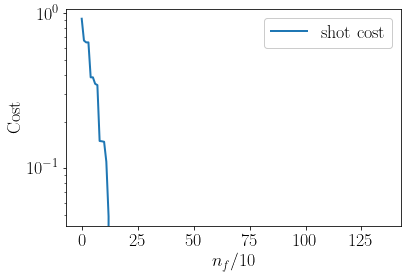

In [35]:
R = 4
ansatz = FlexibleAnsatz(n, 'hef2d')
an_np = ansatz.get_num_parameters()
scl = []
ecl = []
on_hardware = False

def cost(params):
    pvec = params[0:an_np]
    prob_vec = params[an_np:]
    c = compute_msl_shot_and_ideal_cost(pvec, ansatz, prob_vec, rho_prep_circ,
                                        rho, rp, rho_qubits, n, backend,
                                        on_hardware, scl, ecl)[0]
    
    return c

a0 = list(np.random.normal(size=an_np) % (2 * np.pi))
p0 = list(qstate.utils.generate_random_prob_vec(R))
x0 = a0 + p0
result = scipy.optimize.minimize(cost, x0, method="Powell")

plt.plot(get_rolling_mins(scl) , label="shot cost")
plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.ylabel("Cost")
plt.legend()

In [24]:
np.sqrt(10**(-4))

0.01

## Now actually do the real thing

In [36]:
R = 4
ansatz = FlexibleAnsatz(n, 'hef2d')
an_np = ansatz.get_num_parameters()
scl = []
ecl = []
on_hardware = True

def cost(params):
    pvec = params[0:an_np]
    prob_vec = params[an_np:]
    c = compute_msl_shot_and_ideal_cost(pvec, ansatz, prob_vec, rho_prep_circ,
                                        rho, rp, rho_qubits, n, backend,
                                        on_hardware, scl, ecl)[0]
    
    return c

a0 = list(np.random.normal(size=an_np) % (2 * np.pi))
p0 = list(qstate.utils.generate_random_prob_vec(R))
x0 = a0 + p0
result = scipy.optimize.minimize(cost, x0, method="Powell")

plt.plot(get_rolling_mins(scl) , label="shot cost")
#plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.ylabel("Cost")
plt.legend()


KeyboardInterrupt



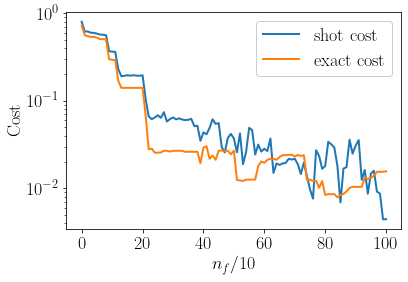

In [47]:
plt.plot(get_rolling_mins(scl) + 0.085 , label="shot cost")
plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.ylabel("Cost")
plt.legend()

In [48]:
ucirc, _ = make_sigma_ansatz_circuits(result.x[0:an_np], ansatz, rho_qubits, backend, n)
ansatz.update_parameters(result.x[0:an_np])
sigma = compute_sigma(result.x[an_np:], ansatz, n)

data_dict = {}
data_dict["backend"] = backend
data_dict["backend_name"] = backend.backend.name()
data_dict["rho"] = rho
data_dict["rho_circ"] = rho_prep_circ
data_dict["sigma"] = sigma
data_dict["final_cost"] = np.real(rho.purity() + sigma.purity() - 2 * np.trace(np.matmul(rho, sigma)))
data_dict["sigma_ansatz"] = ansatz
data_dict["shot_costs"] = scl
data_dict["exact_costs"] = ecl
data_dict["plot_offset"] = 0.085
data_dict["window"] = 10
data_dict["data"] = "14 June 2022"
data_dict["optimal_cost"] = compute_optimal_DHS(rho, R)

fname = f"pickled_runs/jakarta_2q_ghz_prep_run_rank_{R}_approx.pkl"
with open(fname, 'wb') as f:
    pickle.dump(data_dict, f)

/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_43531/1578741264.py:22: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dump(data_dict, f)
/var/folders/2w/_70fq7w11c36fkhz8pnqp8gw0000gp/T/ipykernel_43531/1578741264.py:22: DeprecationWarning: The `backends` provider attribute is deprecated. Please use `provider.backend` (singular) instead. You can continue to use `provider.backends()` to retrieve all backends.
  pickle.dump(data_dict, f)


In [58]:
#with open(fname, 'rb') as f:
#    blah = pickle.load(f)

fname = "csv_runs/jakarta_2q_ghz_prep_run_rank_{R}_approx.csv"
with open(fname, 'w') as f:
    for j in range(len(ecl)):
        if j == 0:
            line = f"{scl[j]},{ecl[j]}"
        else:
            line = f"\n{scl[j]},{ecl[j]}"
        f.write(line)

# Perform the R = 2 optimization

In [59]:
rho = compute_rho_with_tomography(rho_prep_circ, rho_qubits, n, backend)
print(rho)
rp = np.real(rho.purity())
print(rp)

KeyboardInterrupt: 

### First do it classically with shots to verify things will work

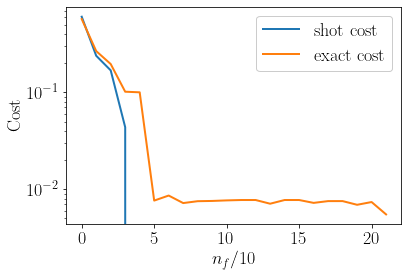

In [16]:
R = 2
ansatz = FlexibleAnsatz(n)
ansatz.insert_arb1q(0)
an_np = ansatz.get_num_parameters()
scl = []
ecl = []
on_hardware = False

def cost(params):
    pvec = params[0:an_np]
    prob_vec = params[an_np:]
    c = compute_msl_shot_and_ideal_cost(pvec, ansatz, prob_vec, rho_prep_circ,
                                        rho, rp, rho_qubits, n, backend,
                                        on_hardware, scl, ecl)[0]
    
    return c

a0 = list(np.random.normal(size=an_np) % (2 * np.pi))
p0 = list(qstate.utils.generate_random_prob_vec(R))
x0 = a0 + p0
result = scipy.optimize.minimize(cost, x0, method="Powell")

plt.plot(get_rolling_mins(scl), label="shot cost")
plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.ylabel("Cost")
plt.legend()

## Now actually do the real thing

0.41443657819257584
0.4142635413642273
0.4141479607800411
0.41442455246705356
0.4148060352044549
0.41462965789679473
0.4145374606677905
0.41446931488983085
0.4145601759271105
0.41457687832366896
0.4144111905498067
0.4145748740360822
0.41429961854079433
0.4143884752904867
0.4389289725062937
0.39195782480797803
0.4058415249234548
0.3922083607563591
0.3941465068530339
0.3953203512831811
0.3915008472381314
0.39157099730367806
0.391203544579386
0.39151220486779126
0.39152757107262537
0.39155897157815556
0.39162978973956464
0.3974609304261476
0.428797966849632
0.3914413867063822
0.40122431441876016
0.3904599538845914
0.39042053622871276
0.3904826691439114
0.3904546091176926
0.3903343518624698
0.39028224038520665
0.39057018970187896
0.3903163132741865
0.3904599538845914
0.3903851271480083
0.39041853194112575
0.39044726006320674
0.3903971528735306
0.557621038557965
4.362814378485308
0.39027155085140897
1.2950629375896285
0.21410589546633885
0.21439175334959892
0.21553668011246496
0.24787470700

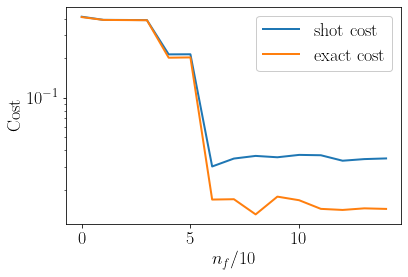

In [17]:
R = 2
ansatz = FlexibleAnsatz(n)
ansatz.insert_arb1q(0)
an_np = ansatz.get_num_parameters()
scl = []
ecl = []
on_hardware = True

def cost(params):
    pvec = params[0:an_np]
    prob_vec = params[an_np:]
    c = compute_msl_shot_and_ideal_cost(pvec, ansatz, prob_vec, rho_prep_circ,
                                        rho, rp, rho_qubits, n, backend,
                                        on_hardware, scl, ecl)[0]
    print(c)
    
    return c

a0 = list(np.random.normal(size=an_np) % (2 * np.pi))
p0 = list(qstate.utils.generate_random_prob_vec(R))
x0 = a0 + p0
result = scipy.optimize.minimize(cost, x0, method="Powell")

plt.plot(get_rolling_mins(scl), label="shot cost")
plt.plot(get_rolling_mins(ecl), label="exact cost")
#plt.axhline(compute_optimal_DHS(rho, R), 0, 10, label="ideal", color="g", linestyle="--")
plt.yscale("log")
plt.xlabel(r"$n_{f} / 10$")
plt.ylabel("Cost")
plt.legend()

In [37]:
ucirc, _ = make_sigma_ansatz_circuits(result.x[0:an_np], ansatz, rho_qubits, backend, n)
ansatz.update_parameters(result.x[0:an_np])
sigma = compute_sigma(result.x[an_np:], ansatz, n)

data_dict = {}
data_dict["backend"] = backend
data_dict["backend_name"] = backend.backend.name()
data_dict["rho"] = rho
data_dict["rho_circ"] = rho_prep_circ
data_dict["sigma"] = sigma
data_dict["final_cost"] = np.real(rho.purity() + sigma.purity() - 2 * np.trace(np.matmul(rho, sigma)))
data_dict["sigma_ansatz"] = ansatz
data_dict["shot_costs"] = scl
data_dict["exact_costs"] = ecl
data_dict["plot_offset"] = 0
data_dict["window"] = 10
data_dict["data"] = "10 June 2022"
data_dict["optimal_cost"] = compute_optimal_DHS(rho, R)

fname = f"pickled_runs/bogota_1q_hadamard_prep_run_rank{R}_approx.pkl"
with open(fname, 'wb') as f:
    pickle.dump(data_dict, f)

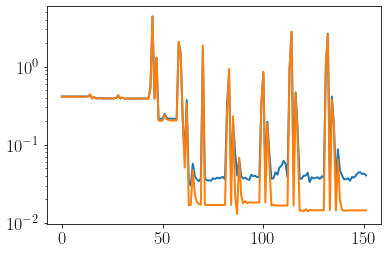

In [41]:
plt.plot(data_dict["shot_costs"])
plt.plot(data_dict["exact_costs"])
plt.yscale("log")

In [24]:
rho.purity() + sigma.purity() - 2 * np.trace(np.matmul(rho, sigma))

(0.014411995648173415+0j)

In [669]:
#with open(fname, 'rb') as f:
#    blah = pickle.load(f)

fname = "csv_runs/belem_1q_hadamard_prep_run.csv"
with open(fname, 'w') as f:
    for j in range(len(exact_cost)):
        if j == 0:
            line = f"{shot_cost[j]},{exact_cost[j]}"
        else:
            line = f"\n{shot_cost[j]},{exact_cost[j]}"
        f.write(line)

In [1]:
x = 2